In [1]:
import numpy as np
import random
import certifi
import os
import torch
from tqdm import tqdm
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models, utils
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from PIL import Image
from fastai.vision.all import xresnet18

os.environ['SSL_CERT_FILE'] = certifi.where()

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [2]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),  # |||
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),  # |||
    # transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # |||
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2))  # |||
])
val_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

full_ds = datasets.ImageFolder(root='data/asl_alphabet', transform=train_transform)

val_pct = 0.2
n_val = int(len(full_ds) * val_pct)
n_train = len(full_ds) - n_val
train_ds, val_ds = random_split(full_ds, [n_train, n_val])
val_ds.dataset.transform = val_transform

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          num_workers=4, pin_memory=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                        num_workers=4, pin_memory=False)

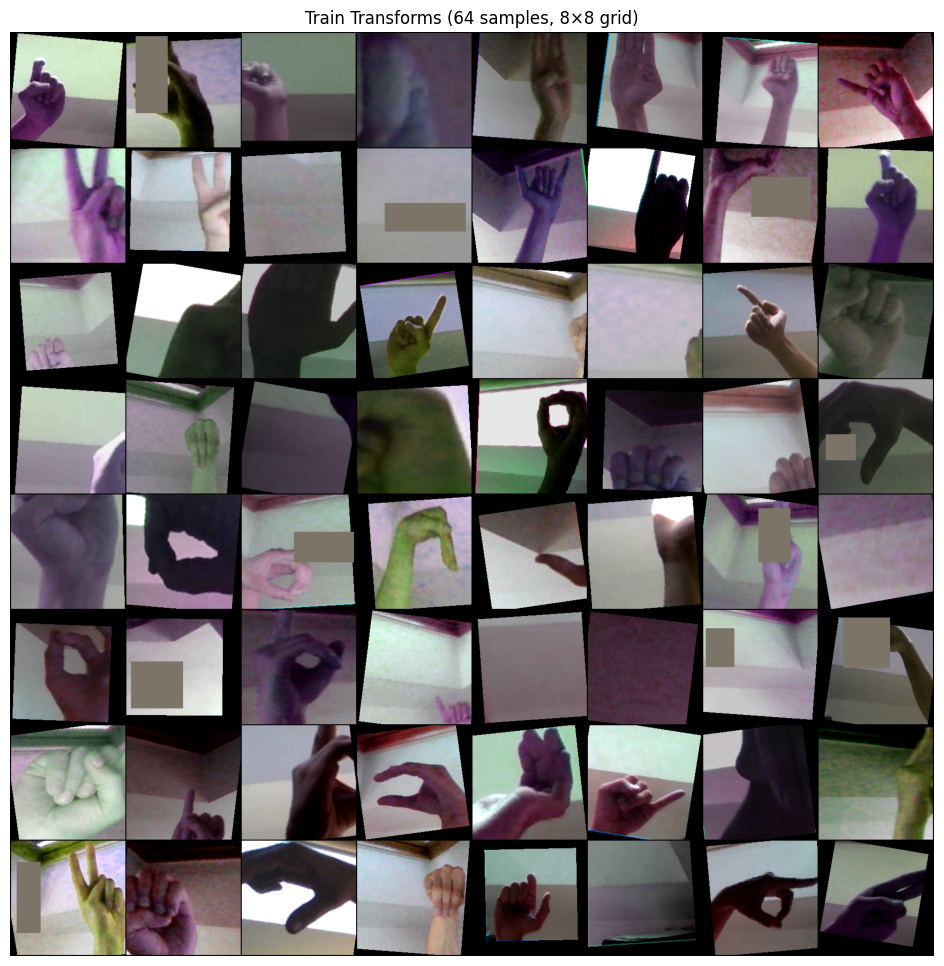

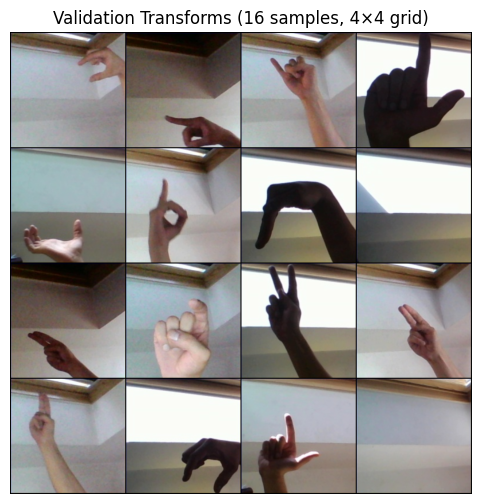

In [3]:
paths = [path for path, _ in datasets.ImageFolder(root='data/asl_alphabet', transform=None).samples]
sample_paths = random.sample(paths, 8)  # 8 images for grid

train_paths = random.sample(paths, 64)
val_paths = random.sample(paths, 16)


# 4. Helper to load and apply a transform to a list of paths
def load_and_apply(paths, transform):
    tensors = []
    for p in paths:
        img = Image.open(p).convert('RGB')
        tensors.append(transform(img))
    return torch.stack(tensors)


# 5. Generate tensors for train and val transforms
batch_train = load_and_apply(train_paths, train_transform)
batch_val = load_and_apply(val_paths, val_transform)

# 6. Denormalization transform to invert Normalize
inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
    std=[1 / s for s in [0.229, 0.224, 0.225]]
)

batch_train = inv_normalize(batch_train)
batch_val = inv_normalize(batch_val)

# 7. Create image grids
grid_train = utils.make_grid(batch_train, nrow=8, padding=2)
grid_val = utils.make_grid(batch_val, nrow=4, padding=2)

# 8. Plot
plt.figure(figsize=(12, 12))
plt.imshow(grid_train.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
plt.title('Train Transforms (64 samples, 8×8 grid)')

plt.figure(figsize=(6, 6))
plt.imshow(grid_val.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
plt.title('Validation Transforms (16 samples, 4×4 grid)')

plt.show()

In [4]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(full_ds.classes))
model.to(device)

# model = xresnet18(pretrained=True, n_out=len(full_ds.classes)).to(device)
#
criterion = nn.CrossEntropyLoss()

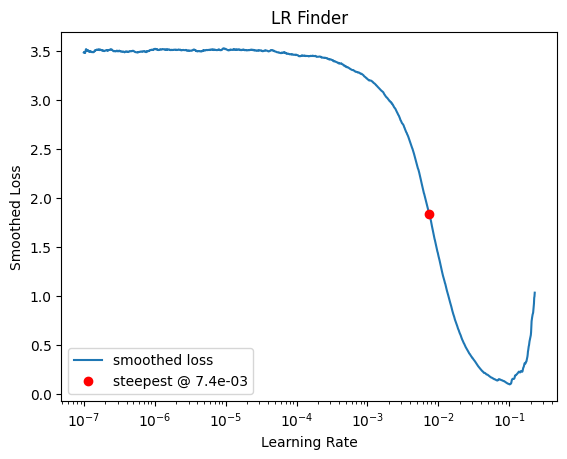

steepest slope at lr = 7.41e-03
suggested lr = 7.41e-03


In [5]:
def lr_finder(model, train_loader, criterion, device,
              init_value=1e-7, final_value=10, beta=0.98):
    """
    Returns:
      lrs    : list of learning rates used
      losses : list of smoothed losses
      checkpoint : copy of initial model weights
    """
    model.train()
    checkpoint = model.state_dict()  # save for reset

    optimizer = optim.SGD(model.parameters(), lr=init_value)
    num = len(train_loader) - 1
    mult = (final_value / init_value) ** (1 / num)
    lr = init_value
    avg_loss, best_loss, batch_num = 0.0, float("inf"), 0
    lrs, losses = [], []

    for inputs, labels in tqdm(train_loader, desc="LR Finder", leave=False):
        batch_num += 1
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # smooth the loss
        avg_loss = beta * avg_loss + (1 - beta) * loss.item()
        smoothed = avg_loss / (1 - beta ** batch_num)

        # record
        lrs.append(lr)
        losses.append(smoothed)
        if smoothed < best_loss:
            best_loss = smoothed

        # stop if loss explodes
        if smoothed > 10 * best_loss:
            break

        # step
        loss.backward()
        optimizer.step()

        # update lr
        lr *= mult
        for pg in optimizer.param_groups:
            pg['lr'] = lr

    # restore original weights
    model.load_state_dict(checkpoint)
    return lrs, losses


def plot_lr_finder_with_suggestion(lrs, losses,
                                   skip_start: int = 10,
                                   skip_end: int = 5):
    """
    lrs:    list of LRs tried (in increasing order)
    losses: list of smoothed losses recorded
    """
    lrs_np = np.array(lrs)
    loss_np = np.array(losses)
    log_lrs = np.log10(lrs_np)

    # 1. Compute gradient of loss wrt log10(lr)
    grads = np.gradient(loss_np, log_lrs)

    # 2. Ignore the first `skip_start` and last `skip_end` points
    valid_slice = slice(skip_start, len(grads) - skip_end)
    grads_valid = grads[valid_slice]
    lrs_valid = lrs_np[valid_slice]

    # 3. Find the index of the steepest (most negative) slope
    idx_rel = np.argmin(grads_valid)
    idx = idx_rel + skip_start
    lr_steep = lrs_np[idx]

    # 4. Back off by factor of `backoff`
    suggested = lr_steep

    # --- Plot ---
    fig, ax = plt.subplots()
    ax.plot(lrs_np, loss_np, label="smoothed loss")
    ax.set_xscale('log')
    ax.set_xlabel("Learning Rate")
    ax.set_ylabel("Smoothed Loss")
    ax.set_title("LR Finder")

    # mark the steepest point and the suggested LR
    ax.plot(lr_steep, loss_np[idx], 'o', c='red', label=f"steepest @ {lr_steep:.1e}")
    ax.legend()
    plt.show()

    print(f"steepest slope at lr = {lr_steep:.2e}")

    return suggested


lrs, losses = lr_finder(model, train_loader, criterion, device)
suggested_lr = plot_lr_finder_with_suggestion(lrs, losses)

print(f"suggested lr = {suggested_lr:.2e}")

In [6]:
def train_epoch(loader, epoch):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed = 0  # <- count of samples seen
    pbar = tqdm(loader, desc=f"Epoch {epoch} [Train]", unit="batch")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # forward + backward
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # stats
        batch_size = inputs.size(0)
        running_loss += loss.item() * batch_size
        running_corrects += (outputs.argmax(1) == labels).sum().item()
        processed += batch_size  # <- increment by actual batch size

        # compute true averages
        avg_loss = running_loss / processed
        avg_acc = running_corrects / processed

        # update progress bar
        pbar.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{avg_acc:.4f}")

    total = len(loader.dataset)
    return running_loss / total, running_corrects / total


def eval_epoch(loader, epoch):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed = 0

    all_preds = []
    all_labels = []

    pbar = tqdm(loader, desc=f"Epoch {epoch} [Val]  ", unit="batch")
    with torch.no_grad():
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # stats
            batch_size = inputs.size(0)
            running_loss += loss.item() * batch_size

            preds = outputs.argmax(1)
            running_corrects += (preds == labels).sum().item()
            processed += batch_size

            # accumulate for F1
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

            # update bar
            avg_loss = running_loss / processed
            avg_acc = running_corrects / processed
            pbar.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{avg_acc:.4f}")

    # final metrics
    total = len(loader.dataset)
    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total

    # compute F1 (weighted to account for class imbalance)
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_labels).numpy()
    epoch_f1 = f1_score(y_true, y_pred, average='weighted')

    return epoch_loss, epoch_acc, epoch_f1

In [7]:
optimizer = optim.SGD(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=suggested_lr, momentum=0.9, weight_decay=1e-4,
)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [8]:
for name, param in model.named_parameters():
    param.requires_grad = name.startswith("fc.")

# # 1. First, freeze all parameters
# for param in model.parameters():
#     param.requires_grad = False
#
# # 2. Then un-freeze only the head (the last Linear layer at index 11)
# for name, param in model.named_parameters():
#     # names look like "11.weight" and "11.bias" for that layer
#     if name.startswith("11."):
#         param.requires_grad = True
#
# # 3. Confirm
# print("Trainable params:")
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(" ", name)

num_epochs = 5
for epoch in range(1, num_epochs + 1):
    # At the start of epoch 5, unfreeze the entire model
    if epoch == 3:
        for param in model.parameters():
            param.requires_grad = True
        # Re-build optimizer to include all params
        optimizer = optim.SGD(model.parameters(), lr=suggested_lr * 0.1, momentum=0.9, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        print("→ Unfroze backbone; now fine-tuning all layers")

    # Train & validate
    train_loss, train_acc = train_epoch(train_loader, epoch)
    val_loss, val_acc, val_f1 = eval_epoch(val_loader, epoch)
    scheduler.step()
    print(f"Epoch {epoch:02d} — "
          f"Train: loss {train_loss:.4f}, acc {train_acc:.4f} | "
          f"Val:   loss {val_loss:.4f}, acc {val_acc:.4f}, f1 {val_f1:.4f}")

torch.save(model, "final.pth")

Epoch 1 [Val]  : 100%|██████████| 544/544 [00:15<00:00, 34.70batch/s, acc=0.9764, loss=0.0896]


Epoch 01 — Train: loss 0.1779, acc 0.9541 | Val:   loss 0.0896, acc 0.9764, f1 0.9767


Epoch 2 [Val]  : 100%|██████████| 544/544 [00:15<00:00, 35.76batch/s, acc=0.9869, loss=0.0595]


Epoch 02 — Train: loss 0.0976, acc 0.9750 | Val:   loss 0.0595, acc 0.9869, f1 0.9870
→ Unfroze backbone; now fine-tuning all layers


Epoch 3 [Val]  : 100%|██████████| 544/544 [00:15<00:00, 34.72batch/s, acc=0.9995, loss=0.0025]


Epoch 03 — Train: loss 0.0182, acc 0.9957 | Val:   loss 0.0025, acc 0.9995, f1 0.9995


Epoch 4 [Val]  : 100%|██████████| 544/544 [00:15<00:00, 35.24batch/s, acc=0.9999, loss=0.0009]


Epoch 04 — Train: loss 0.0044, acc 0.9992 | Val:   loss 0.0009, acc 0.9999, f1 0.9999


Epoch 5 [Val]  : 100%|██████████| 544/544 [00:15<00:00, 35.12batch/s, acc=1.0000, loss=0.0005]


Epoch 05 — Train: loss 0.0025, acc 0.9996 | Val:   loss 0.0005, acc 1.0000, f1 1.0000
